# Credible intervals


There is inherent uncertainty in any data analysis, particularly when dealing with observational data. In order to account for that uncertainty appropriately, it's necessary to quantify it as part of the inference process.

In frequentist statistics, the approach to doing this is to compute confidence intervals. Confidence intervals offer a range of values around a point estimate that describe its uncertainty.

The Bayesian equivalent is the credible interval, which is conceptually similar, but statistically much different (and intuitively much easier). Credible intervals describe the uncertainty in what the analysis is trying to estimate. While Bayesian inference produces a distribution of estimated values, the credible interval simply describes the part of the distribution that contains a certain % of the values.

The numbers presented in the previous chapter fall foul of the same uncertainty as any other analysis. In order to account for this, we need to compute credible intervals around each value. So, if we say Messi's estimated conversion rate is 15%, the 95% credible interval (say, between 12% and 18%) would mean that Messi's conversion rate has a 95% probability of falling in that range.

In [1]:
%load_ext autoreload
%autoreload 2
from scipy.stats import beta
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import numpy as np
import matplotlib.cm as cm

First, we recreate the beta prior model from last chapter, and plot the prior distribution of the population, and the posterior distribution for several notable players.

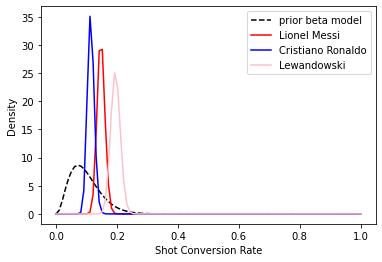

In [2]:
df = pd.read_csv('fbrefshootingdata.csv', encoding='utf-8-sig')
df = df[(df.npG >= 1) & (df.Shots >= 10)].reset_index(drop=True)
df['Conv'] = df['npG']/df['Shots']
bf = beta.fit(df['Conv'], floc=0, fscale=1)
df['Eb_Conv'] = (df['npG']+bf[0])/(df['Shots']+bf[0]+bf[1])

fig,ax = plt.subplots()

def distribution_plotter(a, b, ax, label, color, ls):
    x = np.linspace(0,1,100)
    y = beta.pdf(x, a, b)
    ax.plot(x,y,label=label,ls=ls,color=color)

distribution_plotter(bf[0], bf[1], ax, 'prior beta model', 'k', '--') 
for player,color in zip(['Lionel Messi','Cristiano Ronaldo','Lewandowski'],['r','b','pink']):
    dfp = df[df.Player.str.contains(player)]
    a = dfp['npG'] + bf[0]
    b = dfp['Shots'] + bf[1] - dfp['npG']
    distribution_plotter(a, b, ax, player, color, '-')

ax.set_xlabel('Shot Conversion Rate');
ax.set_ylabel('Density');
ax.legend();

Next, we plot the 95% credible intervals for the posterior distributions of each player.Shown is the example of Lionel Messi

In [3]:
def player_cred_intv(ranges, player, ax, ls, color):
    dfp = df[df.Player.str.contains(player)]
    a = dfp['npG'] + bf[0]
    b = dfp['Shots'] + bf[1] - dfp['npG']
    lower, upper = beta.ppf(ranges, a, b)
    x = np.linspace(0,1,1000)
    y = beta.pdf(x, a, b)
    ax.plot(x,beta.pdf(x,bf[0],bf[1]),label='prior',ls='--',color='k')
    ax.plot(x,y,label=player+' '+str(100 - int(2*ranges[0]*100))+'% credible intervals',ls=ls,color=color)
    ax.plot([lower, upper], [0,0], 'k')
    xcv = np.linspace(lower,upper,1000)
    ycv = beta.pdf(xcv,a,b)
    ax.fill_between(xcv,ycv,0,color=color,alpha=0.2)

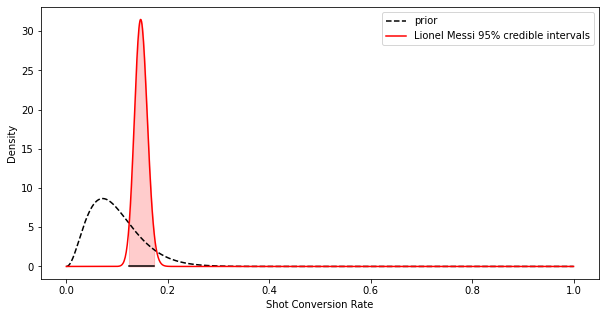

In [4]:
fig, ax = plt.subplots(figsize=(10,5),)
player_cred_intv([0.025,0.975],'Lionel Messi',ax,ls='-',color='r')
ax.set_xlabel('Shot Conversion Rate');
ax.set_ylabel('Density');
ax.legend();

Finally we show the 95% credible intervals for several notable players who are generally regarded as great finishers by the football fans.

In [13]:
def plot_multiple_cred_intervals(ranges, players, ax):
    interval = str(100 - int(2*ranges[0]*100))+'% credible intervals'
    for i, player in enumerate(players):
        dfp = df[df.Player.str.contains(player)]
        a = dfp['npG'] + bf[0]
        b = dfp['Shots'] + bf[1] - dfp['npG']
        ax.scatter(dfp.Eb_Conv.values,i,color='k',zorder=3)
        lower, upper = beta.ppf(ranges, a, b)
        print(player,dfp.Eb_Conv.values - lower,upper-dfp.Eb_Conv.values)
        ax.errorbar(dfp.Eb_Conv.values,i,xerr=[dfp.Eb_Conv.values - lower,upper - dfp.Eb_Conv.values],
                    color='r',zorder=2,capsize=6)
    ax.axvline(bf[0]/(bf[0]+bf[1]),ls='--',color='r')
    ax.set_yticks([i for i in range(len(players))])
    ax.set_yticklabels(players)
    ax.set_title('Empirical Bayes Estimates of Conversion Rates',fontsize=20,color='k')

Lionel Messi [0.02396784] [0.02567595]
Lewandowski [0.02994573] [0.03177376]
Ronaldo [0.02113184] [0.02297473]
Griezmann [0.03464625] [0.03820277]
Kylian Mbappé [0.03397611] [0.03636347]
Erling [0.05802952] [0.06264358]


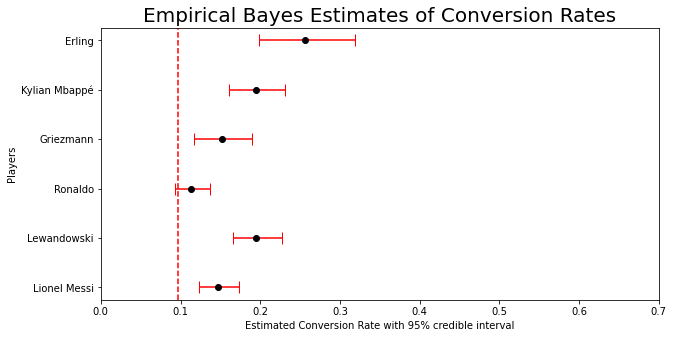

In [14]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set_xlim(0,0.7)
players = ['Lionel Messi','Lewandowski','Ronaldo','Griezmann','Kylian Mbappé','Erling']
plot_multiple_cred_intervals([0.025,0.975],players,ax)
ax.set_xlabel('Estimated Conversion Rate with 95% credible interval');
ax.set_ylabel('Players');